## Introduction

## Data preparation

In [26]:
# !pip install workalendar
# !pip install openpyxl

import pandas as pd
import matplotlib.pyplot as plt
from workalendar.europe import Poland

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.ensemble import RandomForestRegressor


### Loading the dataset

In [47]:
file_path = 'Car_accidents_Poland.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')
df['Date'] = pd.to_datetime(df['Date'],format='%d.%m.%Y')
df.set_index('Date', inplace=True)
df = df.sort_index()
df.index.freq = 'D'
df

,Interventions,Arrested_red-handed,Detained_wanted,Drivers_under_the_influence_of_alcohol,Road_accidents,Killed_in_accidents,Injured_in_accidents
Date,,,,,,,
2022-06-15,18116,658,345,277,87,5,95
2022-06-16,15026,677,219,388,65,7,71
2022-06-17,18299,708,345,398,76,10,83
2022-06-18,18769,708,258,404,71,6,72
2022-06-19,16747,739,197,440,59,3,68
...,...,...,...,...,...,...,...
2024-06-14,17103,556,424,237,68,5,73
2024-06-15,17654,599,224,353,56,2,64
2024-06-16,15286,528,237,319,51,5,55


### Adding the exogenous data

In [48]:
df['Day_of_Week'] = df.index.day_name()
day_of_week_columns = pd.get_dummies(df['Day_of_Week'], dtype=float)
df = df.merge(day_of_week_columns, left_index=True, right_index=True)
df

,Interventions,Arrested_red-handed,Detained_wanted,Drivers_under_the_influence_of_alcohol,Road_accidents,Killed_in_accidents,Injured_in_accidents,Day_of_Week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Date,,,,,,,,,,,,,,,
2022-06-15,18116,658,345,277,87,5,95,Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-06-16,15026,677,219,388,65,7,71,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-06-17,18299,708,345,398,76,10,83,Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-18,18769,708,258,404,71,6,72,Saturday,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-06-19,16747,739,197,440,59,3,68,Sunday,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,17103,556,424,237,68,5,73,Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-15,17654,599,224,353,56,2,64,Saturday,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-06-16,15286,528,237,319,51,5,55,Sunday,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [49]:
cal = Poland()
def get_holidays(start_year, end_year):
    holidays = []
    for year in range(start_year, end_year + 1):
        holidays.extend(cal.holidays(year))
    return holidays
holidays = get_holidays(2022, 2024)
additional_holidays = [
    (pd.Timestamp('2024-10-31'), 'Halloween'),
    (pd.Timestamp('2024-11-29'), 'Andrzejki'),
    (pd.Timestamp('2024-05-02'), 'Day before Constitution Day'),
    (pd.Timestamp('2024-06-23'), 'Father\'s Day'),
    (pd.Timestamp('2024-12-24'), 'Christmas Eve'),

    (pd.Timestamp('2023-10-31'), 'Halloween'),
    (pd.Timestamp('2023-11-29'), 'Andrzejki'),
    (pd.Timestamp('2023-05-02'), 'Day before Constitution Day'),
    (pd.Timestamp('2023-06-23'), 'Father\'s Day'),
    (pd.Timestamp('2023-12-24'), 'Christmas Eve'),

    (pd.Timestamp('2022-10-31'), 'Halloween'),
    (pd.Timestamp('2022-11-29'), 'Andrzejki'),
    (pd.Timestamp('2022-05-02'), 'Day before Constitution Day'),
    (pd.Timestamp('2022-06-23'), 'Father\'s Day'),
    (pd.Timestamp('2022-12-24'), 'Christmas Eve'),
]
all_holidays = holidays + additional_holidays
index_dates = df.index
valid_holidays = []
for date, name in all_holidays:
    if pd.Timestamp(date) in index_dates:
        valid_holidays.append((pd.Timestamp(date), name))
    preceding_day = pd.Timestamp(date) - pd.Timedelta(days=1)
    if preceding_day in index_dates:
        valid_holidays.append((preceding_day, f'{name} (Eve)'))
holidays_df = pd.DataFrame(valid_holidays, columns=['date', 'name'])
df['is_holiday'] = df.index.to_series().apply(lambda x: x in holidays_df['date'].values).astype(int)
df

,Interventions,Arrested_red-handed,Detained_wanted,Drivers_under_the_influence_of_alcohol,Road_accidents,Killed_in_accidents,Injured_in_accidents,Day_of_Week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,is_holiday
Date,,,,,,,,,,,,,,,,
2022-06-15,18116,658,345,277,87,5,95,Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2022-06-16,15026,677,219,388,65,7,71,Thursday,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2022-06-17,18299,708,345,398,76,10,83,Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2022-06-18,18769,708,258,404,71,6,72,Saturday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2022-06-19,16747,739,197,440,59,3,68,Sunday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,17103,556,424,237,68,5,73,Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2024-06-15,17654,599,224,353,56,2,64,Saturday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2024-06-16,15286,528,237,319,51,5,55,Sunday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [29]:
cal = Poland()
cal.holidays(2024)

[(datetime.date(2024, 1, 1), 'New year'),
 (datetime.date(2024, 1, 6), 'Trzech Kroli'),
 (datetime.date(2024, 3, 31), 'Easter Sunday'),
 (datetime.date(2024, 4, 1), 'Easter Monday'),
 (datetime.date(2024, 5, 1), 'Labour Day'),
 (datetime.date(2024, 5, 3), 'Constitution Day'),
 (datetime.date(2024, 5, 19), 'Pentecost Sunday'),
 (datetime.date(2024, 5, 30), 'Corpus Christi'),
 (datetime.date(2024, 8, 15), 'Assumption of Mary to Heaven'),
 (datetime.date(2024, 11, 1), 'All Saints Day'),
 (datetime.date(2024, 11, 11), 'Independence Day'),
 (datetime.date(2024, 12, 25), 'Christmas Day'),
 (datetime.date(2024, 12, 26), 'Boxing Day')]

## Analysis for all Interventions

### Data visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


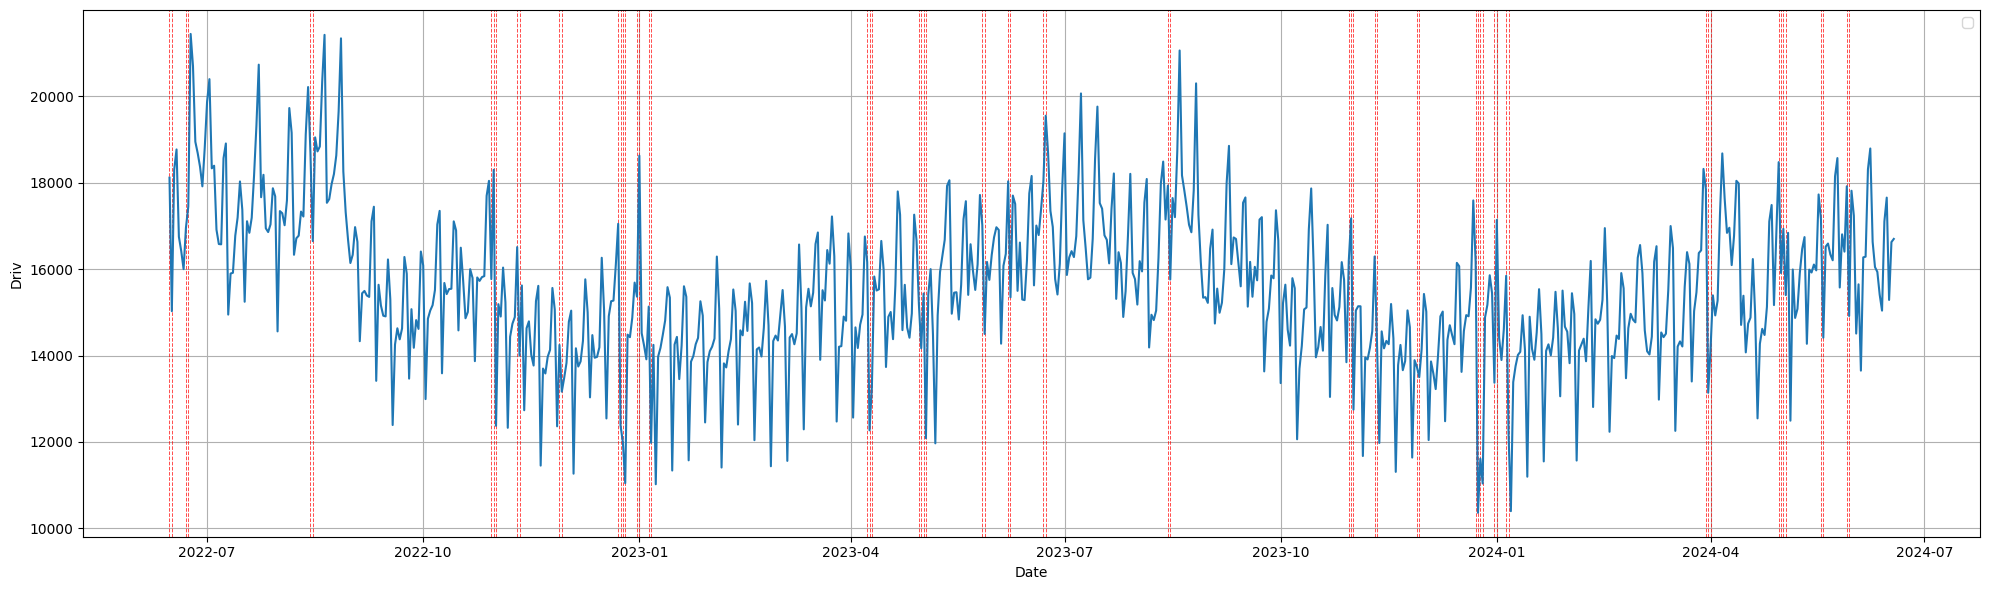

In [51]:
plt.figure(figsize=(20, 6)) 

holidays = df.index[df['is_holiday'] == True]
for holiday in holidays:
    plt.axvline(x=holiday, color='red', linestyle='--', linewidth=0.7, alpha=0.7)

plt.plot(df.index, df["Interventions"])
plt.xlabel('Date')
plt.ylabel('Driv')
plt.title('')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [31]:
# fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 20), sharex=True)
# holidays = df.index[df['is_holiday'] == True]
# weekends = df.index[df['is_weekend'] == True]

# for i, col in enumerate(columns):
#     df[col].plot(ax=axes[i], title=col.strip(), legend=False)
#     axes[i].set_ylabel(col.strip())
    
#     # Plot vertical lines on holidays
#     for holiday in holidays:
#         axes[i].axvline(x=holiday, color='r', linestyle='--', lw=1)
      
#     for weekend in weekends:
#         axes[i].axvline(x=weekend, color='g', linestyle='--', lw=1)

# plt.tight_layout()
# plt.show()

### Holt-Winters analysis

### Autoarima analysis

In [52]:
train = df.iloc[:-7]
test  = df.iloc[-7:]
len(train)

start=len(train)
end=start+len(test)-1
len(train)

728

In [53]:
model_all_interventions = auto_arima(
    df["Interventions"],
    exogenous = df[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']],
    start_p=0,
    start_q=0,
    max_p=5,
    max_q =5,
    seasonal=True,
    m=7,
    trace = True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1
)
model_all_interventions.summary()

C:\Users\Adam\AppData\Roaming\Python\Python312\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=12940.170, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=12466.425, Time=0.58 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=12592.692, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=12938.171, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=12865.184, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=12375.514, Time=0.89 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=12434.549, Time=3.26 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=12239.088, Time=1.69 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=12641.827, Time=0.52 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=12440.422, Time=2.87 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=12549.453, Time=1.19 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=3.10 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=12230.017, Time=1.83 sec
 ARIMA(2,1,0)(0,0,1)[7] interce

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  735
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -6109.009
Date:                             Thu, 20 Jun 2024   AIC                          12230.017
Time:                                     19:34:21   BIC                          12257.608
Sample:                                 06-15-2022   HQIC                         12240.659
                                      - 06-18-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.4634      3.279     -0.751      0.452      -8.890       3.963
ar.L1         -0.3815      0.028    -13.544      0.000      -0.437      -0.326
ar.L2         -0.1039      0.027     -3.877      0.000      -0.156      -0.051
ar.S.L7        0.9841      0.005    197.762      0.000       0.974       0.994
ma.S.L7       -0.8673      0.022    -40.146      0.000      -0.910      -0.825
sigma2      9.575e+05   2.97e+04     32.196      0.000    8.99e+05    1.02e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):               545.13
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.48
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
model_all_interventions = SARIMAX(train['Interventions'], exog=train[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']], 
                      order=(2,1,0), seasonal_order=(1,0,1,7)).fit() #Best model:  ARIMA(2,1,0)(1,0,1)[7] intercept
model_all_interventions.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       Interventions   No. Observations:                  728
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -6007.084
Date:                             Thu, 20 Jun 2024   AIC                          12040.169
Time:                                     19:48:50   BIC                          12099.825
Sample:                                 06-15-2022   HQIC                         12063.189
                                      - 06-11-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_holiday  -433.7840     91.748     -4.728      0.000    -613.606    -253.962
Friday      1286.2420   1.15e+04      0.112      0.911   -2.13e+04    2.38e+04
Monday      -196.2756   1.15e+04     -0.017      0.986   -2.28e+04    2.24e+04
Saturday    1198.3212   1.15e+04      0.104      0.917   -2.14e+04    2.38e+04
Sunday     -1533.4741   1.15e+04     -0.133      0.894   -2.41e+04     2.1e+04
Thursday     -66.0453   1.15e+04     -0.006      0.995   -2.27e+04    2.25e+04
Tuesday     -368.3394   1.15e+04     -0.032      0.974   -2.29e+04    2.22e+04
Wednesday   -320.4288   1.15e+04     -0.028      0.978   -2.29e+04    2.23e+04
ar.L1         -0.3646      0.029    -12.670      0.000      -0.421      -0.308
ar.L2         -0.1010      0.032     -3.178      0.001      -0.163      -0.039
ar.S.L7        0.7673      0.119      6.435      0.000       0.534       1.001
ma.S.L7       -0.6717      0.135     -4.969      0.000      -0.937      -0.407
sigma2      9.015e+05   2.87e+04     31.371      0.000    8.45e+05    9.58e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               991.00
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.45
Prob(H) (two-sided):                  0.27   Kurtosis:                         8.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

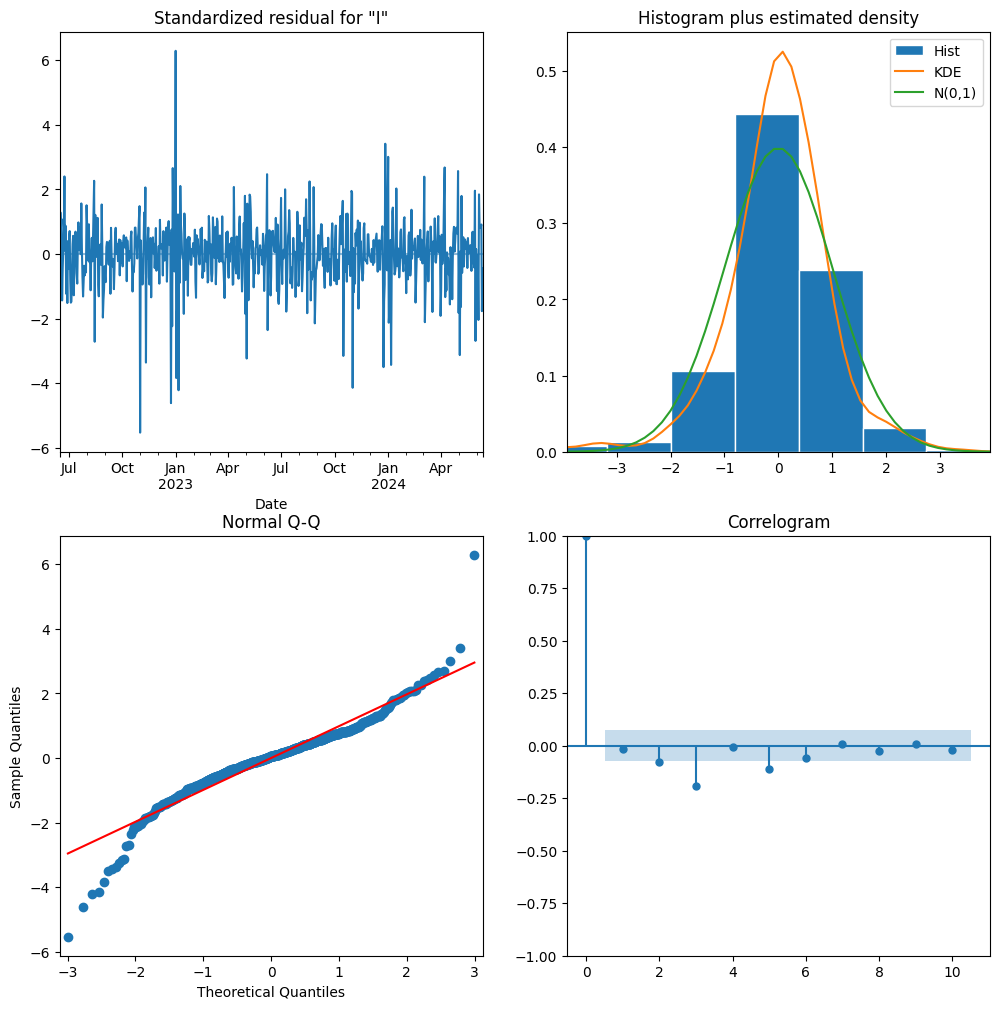

In [55]:
diagnostics = model_all_interventions.plot_diagnostics(figsize=(12, 12))

### Predicting for 1 week

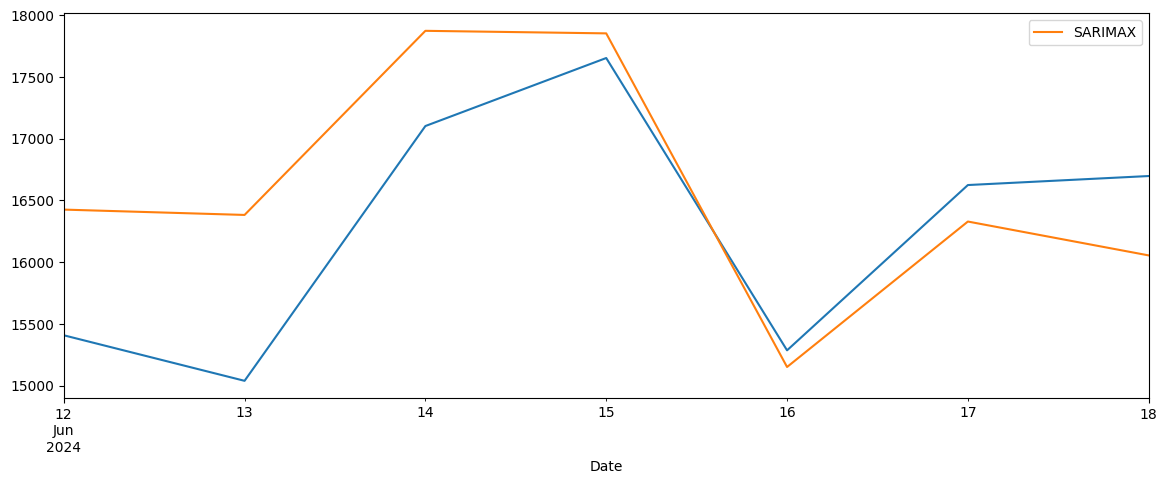

In [56]:
predictions_all_interventions=model_all_interventions.predict(start=start,exog=test[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']],end=end,dynamic=False).rename('SARIMAX')
ax=test['Interventions'].plot(figsize=(14,5))
predictions_all_interventions.plot(legend=True)
for x in test.query('is_holiday==1').index:
    ax.axvline(x=x,color='r')

In [57]:
mean_absolute_percentage_error(test['Interventions'],predictions_all_interventions)*100

3.9566536906776038

## Analysis for drunken sailors

### Data visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


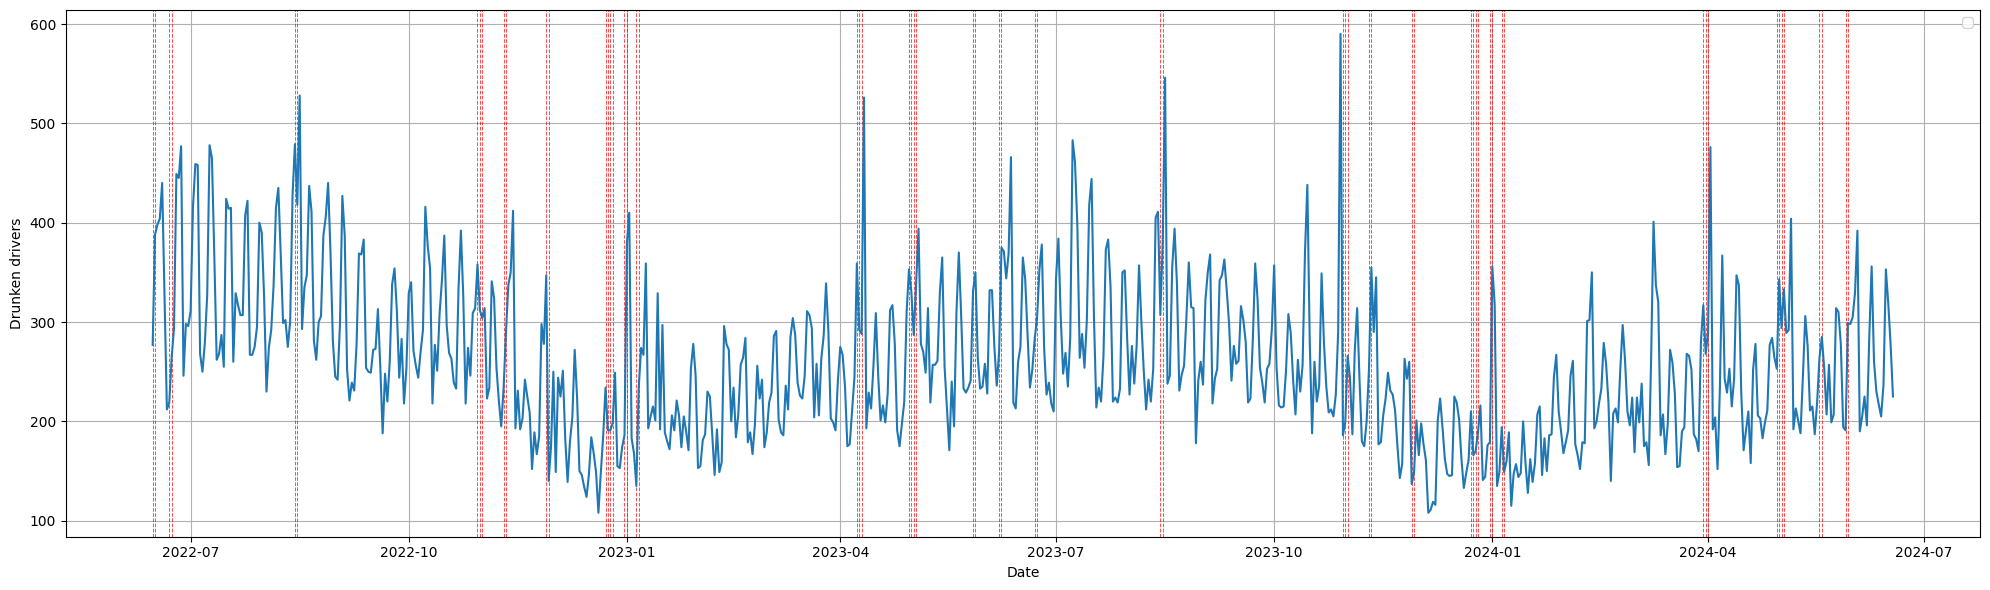

In [58]:
plt.figure(figsize=(20, 6)) 

holidays = df.index[df['is_holiday'] == True]
for holiday in holidays:
    plt.axvline(x=holiday, color='red', linestyle='--', linewidth=0.7, alpha=0.7)

plt.plot(df.index, df["Drivers_under_the_influence_of_alcohol"])
plt.xlabel('Date')
plt.ylabel('Drunken drivers')
plt.title('')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

### Holt-Winters analysis

In [ ]:
#

### Autoarima analysis

In [59]:
train = df.iloc[:-7]
test  = df.iloc[-7:]
len(train)

start=len(train)
end=start+len(test)-1
len(train)

728

In [60]:
model_drunken_drivers = auto_arima(
    df["Drivers_under_the_influence_of_alcohol"],
    exogenous = df[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']],
    start_p=0,
    start_q=0,
    max_p=5,
    max_q =5,
    seasonal=True,
    m=7,
    trace = True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1
)
model_drunken_drivers.summary()

C:\Users\Adam\AppData\Roaming\Python\Python312\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=8305.768, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=8161.206, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=8119.282, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=8303.769, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=8209.112, Time=0.12 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=8059.343, Time=1.18 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=8205.141, Time=0.49 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=7962.216, Time=1.34 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=8012.468, Time=0.62 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=3.37 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=8161.210, Time=0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  735
Model:             SARIMAX(4, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood               -3965.890
Date:                                Thu, 20 Jun 2024   AIC                           7947.779
Time:                                        19:50:51   BIC                           7984.567
Sample:                                    06-15-2022   HQIC                          7961.969
                                         - 06-18-2024                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3720      0.030     12.253      0.000       0.312       0.431
ar.L2         -0.0900      0.045     -1.988      0.047      -0.179      -0.001
ar.L3         -0.0826      0.044     -1.874      0.061      -0.169       0.004
ar.L4         -0.0897      0.043     -2.066      0.039      -0.175      -0.005
ma.L1         -0.9322      0.021    -43.604      0.000      -0.974      -0.890
ma.S.L7        0.2232      0.040      5.554      0.000       0.144       0.302
ma.S.L14       0.1997      0.035      5.704      0.000       0.131       0.268
sigma2      2878.4640     96.418     29.854      0.000    2689.489    3067.439
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               527.09
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.89
Prob(H) (two-sided):                  0.44   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
model_drunken_drivers = SARIMAX(train['Drivers_under_the_influence_of_alcohol'], exog=train[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']], 
                      order=(4,1,1), seasonal_order=(0,0,2,7)).fit() # Best model:  ARIMA(4,1,1)(0,0,2)[7]          
model_drunken_drivers.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:     Drivers_under_the_influence_of_alcohol   No. Observations:                  728
Model:                 SARIMAX(4, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood               -3835.008
Date:                                    Thu, 20 Jun 2024   AIC                           7702.015
Time:                                            19:51:07   BIC                           7775.438
Sample:                                        06-15-2022   HQIC                          7730.348
                                             - 06-11-2024                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_holiday     6.1615      5.606      1.099      0.272      -4.825      17.148
Friday       -21.3801   2.15e+04     -0.001      0.999   -4.22e+04    4.21e+04
Monday        26.9269   2.15e+04      0.001      0.999   -4.21e+04    4.22e+04
Saturday      48.8062   2.15e+04      0.002      0.998   -4.21e+04    4.22e+04
Sunday        60.2565   2.15e+04      0.003      0.998   -4.21e+04    4.22e+04
Thursday     -36.8309   2.15e+04     -0.002      0.999   -4.22e+04    4.21e+04
Tuesday      -40.1266   2.15e+04     -0.002      0.999   -4.22e+04    4.21e+04
Wednesday    -37.6512   2.15e+04     -0.002      0.999   -4.22e+04    4.21e+04
ar.L1          0.2706      0.033      8.253      0.000       0.206       0.335
ar.L2         -0.0049      0.049     -0.098      0.922      -0.102       0.092
ar.L3          0.0481      0.045      1.076      0.282      -0.040       0.136
ar.L4          0.0113      0.043      0.261      0.794      -0.073       0.096
ma.L1         -0.9265      0.027    -33.823      0.000      -0.980      -0.873
ma.S.L7        0.0385      0.049      0.790      0.429      -0.057       0.134
ma.S.L14       0.0549      0.038      1.461      0.144      -0.019       0.129
sigma2      2231.7289     72.101     30.953      0.000    2090.413    2373.045
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2056.89
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             1.51
Prob(H) (two-sided):                  0.24   Kurtosis:                        10.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

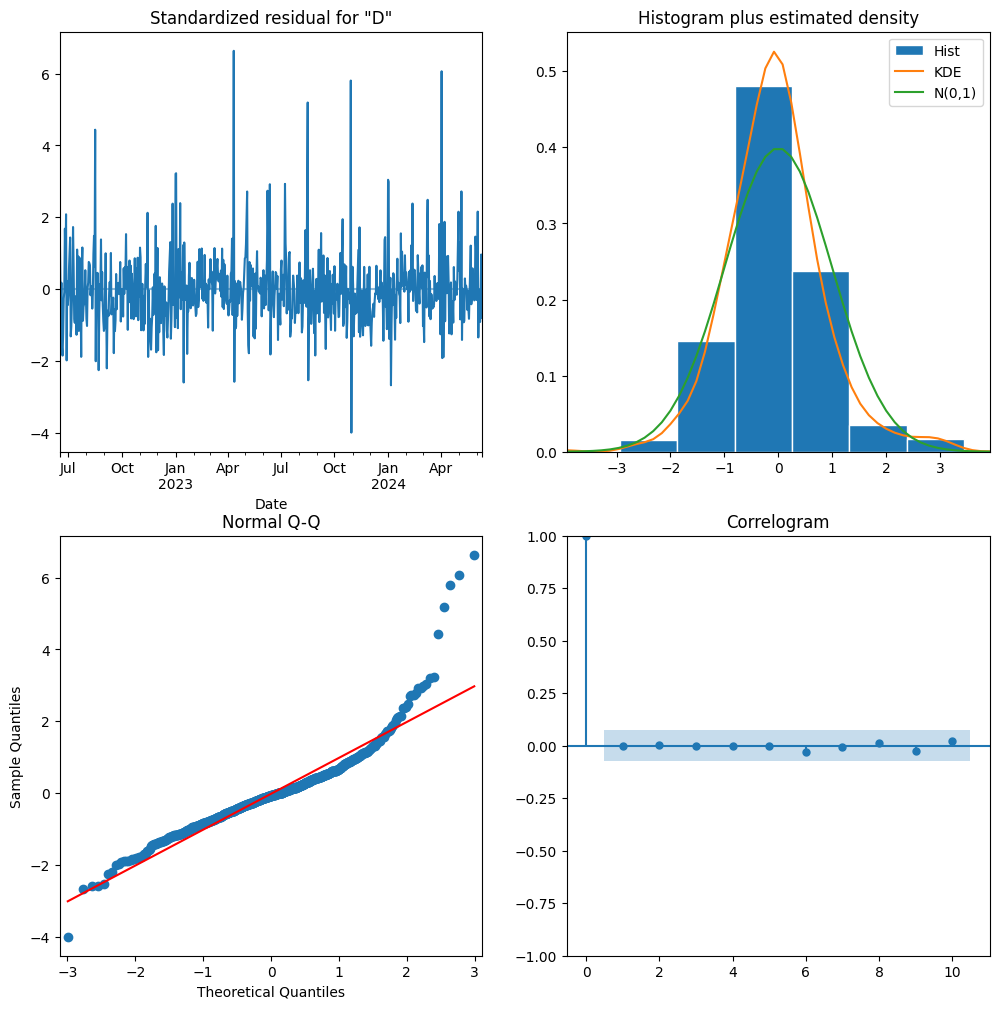

In [42]:
diagnostics = model_drunken_drivers.plot_diagnostics(figsize=(12, 12))

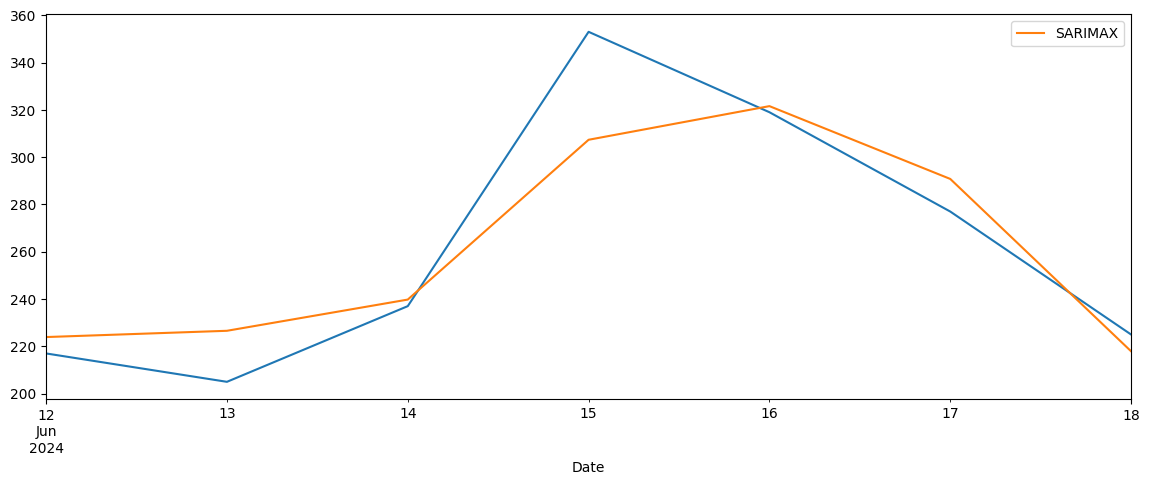

In [62]:
predictions_drunken_drivers=model_drunken_drivers.predict(start=start,exog=test[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']],end=end,dynamic=False).rename('SARIMAX')
ax=test['Drivers_under_the_influence_of_alcohol'].plot(figsize=(14,5))
predictions_drunken_drivers.plot(legend=True)
for x in test.query('is_holiday==1').index:
    ax.axvline(x=x,color='r')

In [63]:
mean_absolute_percentage_error(test['Drivers_under_the_influence_of_alcohol'],predictions_drunken_drivers)*100

5.251477426902099

### Machine Learning approach - Random Forest Regression

In [ ]:
features = [col for col in r_visitors_df.columns if col not in ['rest1', 'rest2', 'rest3', 'rest4', 'total', 'holiday_name','weekday']]

def train_predict_regressor(train_data, test_data, features, target):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(train_data[features], train_data[target])
    predictions = model.predict(test_data[features])
    return predictions

pred_rest1 = train_predict_regressor(train, test, features, 'rest1')
pred_rest2 = train_predict_regressor(train, test, features, 'rest2')
pred_rest3 = train_predict_regressor(train, test, features, 'rest3')
pred_rest4 = train_predict_regressor(train, test, features, 'rest4')

combined_predictions = pred_rest1 + pred_rest2 + pred_rest3 + pred_rest4

plt.figure(figsize=(14, 5))
test['total'].plot(label='Actual Total Visitors')
pd.Series(combined_predictions, index=test.index).plot(label='Combined Predictions', linestyle='--')
plt.legend()
plt.show()

# Calculate and print MAPE for combined predictions
mape_combined = mean_absolute_percentage_error(test['total'], combined_predictions) * 100
print(f'MAPE for Combined Predictions: {mape_combined:.2f}%')

## Summary